# Collatz Python
Calculate length of collatz sequence using python

In [1]:
import time
import os

import datashader as ds
import pandas as pd
import psutil
import pyopencl as cl
import numpy as np


In [2]:
# setup openCL
os.environ["PYOPENCL_COMPILER_OUTPUT"]="1"
os.environ["PYOPENCL_NO_CACHE"]="1"
cl._PYOPENCL_NO_CACHE = True
context = cl.create_some_context(0)
queue = cl.CommandQueue(context)
context

<pyopencl.Context at 0x1c400b10770 on <pyopencl.Device 'gfx1010:xnack-' on 'AMD Accelerated Parallel Processing' at 0x1c47ae7ba90>>

In [3]:
# create openCL program
program = cl.Program(context, """
__kernel void collatz(__global const unsigned int *n, __global unsigned short *l)
{
  unsigned int i = get_global_id(0);
  unsigned short len = 0;
  unsigned long n1 = (unsigned long) n[i];
  while (n1 > 1) {
    len++;
    if (n1 % 2 == 0) {
      n1 = n1 / 2;
    } else {
      n1 = (3*n1 + 1) / 2;
    }
  }
  l[i] = len;
}""").build()

program

C:\Users\Brian\.conda\envs\myenv\Lib\site-packages\pyopencl\__init__.py:519: CompilerWarning: From-source build succeeded, but resulted in non-empty logs:
Build on <pyopencl.Device 'gfx1010:xnack-' on 'AMD Accelerated Parallel Processing' at 0x1c47ae7ba90> succeeded, but said:

1 warning generated.

  lambda: self._prg.build(options_bytes, devices),


Collatz [0, 4294967264]
Run time is 22.433861017227173


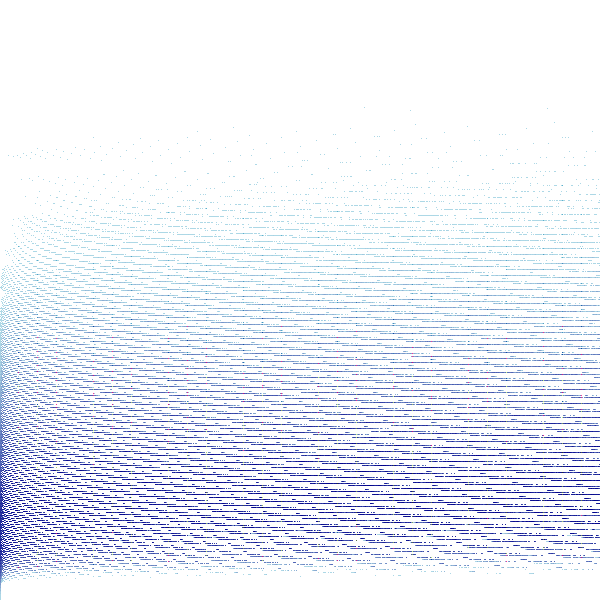

In [4]:
# break problem into `N` runs
NRUNS = 32
NUM = np.iinfo(np.uint32).max//NRUNS

# Create normal numpy arrays, we'll only need to store 1 "run" worth of data
# so we can avoid memory issues with large sizes
n = np.arange(NUM, dtype=np.uint32) - NUM
l = np.zeros(NUM, dtype=np.uint16)

# create GPU arrays
n_cl = cl.Buffer(context, cl.mem_flags.COPY_HOST_PTR, hostbuf=n)
l_cl = cl.Buffer(context, cl.mem_flags.COPY_HOST_PTR, hostbuf=l)

# loop through an make each piece of the image
tstart = time.time()
img = []
for i in range(NRUNS):
    # move `n` to new portion of the input range
    n = n + NUM

    # move data, run progrm, and move data back
    cl.enqueue_copy(queue, n_cl, n)
    program.collatz(queue, n.shape, None, n_cl, l_cl)
    cl.enqueue_copy(queue, l, l_cl)
    queue.finish()

    # render a chunk of the plot
    img.append(ds.tf.shade(ds.Canvas(x_range=(0, NUM*NRUNS), y_range=(0, 800)).points(
        pd.DataFrame({'x': n, 'y': l}, copy=False), 'x', 'y')))

imgTotal = sum(img) # combine all chunks of plot
tstop = time.time()
print(f"Collatz [0, {NUM*NRUNS}]")
print(f"Run time is {tstop-tstart}")
imgTotal


In [5]:
process = psutil.Process()
memory_info = process.memory_info()
rss = memory_info.rss  # Resident Set Size (memory used by the process)

print(f"Memory usage: {rss / (1024 * 1024 * 1024):.2f} GiB")

Memory usage: 1.12 GiB
